## Project1-第8組

### 對ptt普發6000元事件進行情緒分析。

影片連結：https://youtu.be/IExvZT32DoI

動機與目的：
+ 為近期全體人民有感的政治話題
+ 以往發過消費券、三倍券等，但這次金額變大且為現金，引起民眾討論
+ 透過分析可以審視此政策是否真正造福於民眾，或是其實民眾無感

資料來源：
+ 工作流程平台蒐集PTT 八卦版(Gossip)文章
+ 關鍵字:「6000」、「六千」、「普發」
+ 時間: 2023-01-01 ~ 2023-04-19
+ 資料筆數：共 2089 篇文章

## Outline
- 1. 套件設定
- 2. 資料前處理
- 3. 文章內容分析
    - 3.1 內文詞頻分析
    - 3.2 觀察發文頻率
    - 3.3 文章正負面情緒分數分析
    - 3.4 CKIP
    - 3.5 SnowNLP
    - 3.6 TF-IDF
    - 3.7 Bigram 預測模型
- 4. 留言內容分析
    - 4.1 留言詞頻分析
    - 4.2 留言正負面情緒分析
- 5. 結論與討論

## 1.套件設定

In [ ]:
import jieba
import jieba.analyse
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# 設定圖的字體
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 2.文章前處理
#### 斷詞字典

In [ ]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
jieba.set_dictionary('./dict/dict.txt') 

# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
jieba.load_userdict('./dict/user_dict.txt')

# 參數形式手動加入字詞
words = ['蔡英文','普發','6000','登記入帳']
for w in words:
    jieba.add_word(w, freq=None, tag=None)


Building prefix dict from c:\Users\user\Desktop\社群媒體\mid-project\dict\dict.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.u8668680ed47c3c0aa6b856052586c16c.cache
Loading model cost 0.564 seconds.
Prefix dict has been built successfully.


In [ ]:
df = pd.read_csv('raw_data/data_02.csv')
import json
clear_df = df.copy()

#去除有包含空值的筆數
clear_df.dropna(axis=0, how='any')

#用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace(r'\\n\\n', '。', regex=True).replace(r'\n', '', regex=True)

#移除內文中的網址
clear_df['artContent'] = clear_df['artContent'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [ ]:
clear_df = df.copy()
clear_df['artContent'] = clear_df['artContent'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('artContent').reset_index(drop=True)

# 把長度小於1的cmtContent刪掉
sent_df = sent_df[sent_df["artContent"].str.len() > 1]

In [ ]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')

Building prefix dict from c:\Users\user\Desktop\社群媒體\mid-project\dict\dict.txt ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.u8668680ed47c3c0aa6b856052586c16c.cache
Loading model cost 0.589 seconds.
Prefix dict has been built successfully.


斷詞前先將標點符號清除，並清除空字串

In [ ]:
sent_df['artContent'] = sent_df['artContent'].str.replace(r'[^\w\s\d]+', '', regex=True).astype(str)
sent_df = sent_df[sent_df["artContent"].str.len() > 1]

使用jieba進行斷詞

In [ ]:
word_df = sent_df.assign(word = sent_df['artContent'].apply(jieba.lcut)).explode('word')

word_df = word_df.loc[word_df['word'].str.len()>1]


移除停用字

In [ ]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

移除dataframe中的停用字

In [ ]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]

## 3.文章內容分析
#### 計算詞頻後畫視覺化

In [ ]:
freq_df = pd.DataFrame({'freq':noStop_df.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
freq_df = freq_df[clist]
freq_df

,word,freq
0,6000,2165
1,新聞,1570
2,政府,1276
3,完整,1178
4,發現,1106
...,...,...
37219,官職,1
37220,官照,1
37221,官派,1
37222,官宣圖,1


### 視覺化結果：文字雲

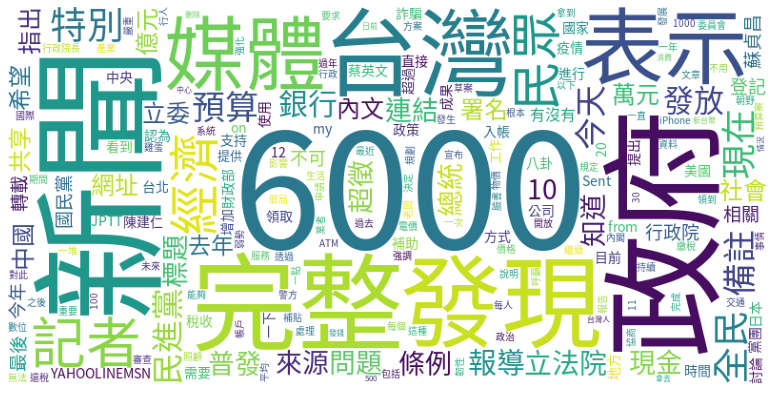

In [ ]:
# 詞頻變成dict
freq_dict = freq_df.set_index('word', inplace=False).to_dict()
freq_dict = freq_dict['freq']

# 繪製文字雲
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' # 設定字型
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=FontPath, max_words=200)
wordcloud.generate_from_frequencies(freq_dict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 發文數趨勢圖

In [ ]:
ptt_df = noStop_df.copy()
ptt_df["artDate"] = pd.to_datetime(ptt_df["artDate"])

In [ ]:
ptt_df["artDate"].describe(datetime_is_numeric=True)

count                           225944
mean     2023-02-19 22:27:12.686515456
min                2023-01-01 09:07:05
25%                2023-01-14 15:46:02
50%                2023-02-18 00:05:55
75%                2023-03-27 16:11:41
max                2023-04-18 20:47:17
Name: artDate, dtype: object

將時間轉日期形式

In [ ]:
ptt_df["artDate"] = ptt_df["artDate"].dt.date

-發文數最高顯示出了1/4 行政院長蘇貞昌宣布，每人能拿到6,000元現金<br>
-3/31、4/1 民眾傳出六千開始陸續匯入帳戶 的時候發文數第二高

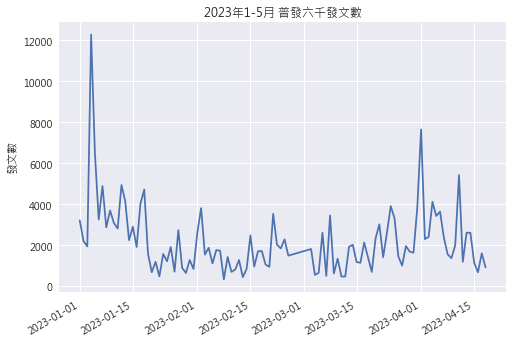

In [ ]:
ptt_line_plot = ptt_df.groupby(["artDate"], as_index=False).size()
fig, ax = plt.subplots()

rolling_hours = 1
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_hours).mean())
plt.title('2023年1-5月 普發六千發文數')
ax.set_ylabel('發文數')
fig.autofmt_xdate()
plt.show()

### liwc情緒分析

In [ ]:
df_sen = df.rename(columns={"artContent": "sentence"})

In [ ]:
sent_df = df_sen.copy()
sent_df["sentence"] = (
    sent_df["sentence"].str.replace(r"[^\w\s\d]+", "", regex=True).astype(str)
)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

In [ ]:
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)
word_df = word_df.loc[word_df["word"].str.len() > 1]

In [ ]:
# 讀取情緒字典
liwc_dict = pd.read_csv("dict/liwc/LIWC_CH.csv", encoding='utf-8')
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [ ]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "artUrl", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artDate,artUrl,word,sentiments
0,2023-01-01,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,確定,affect
1,2023-01-01,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,確定,positive
2,2023-01-01,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,發現,NaN
3,2023-01-01,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,蔡英文,NaN
4,2023-01-01,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,決定,affect
...,...,...,...,...
239917,2023-04-18,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,YAHOOLINEMSN,NaN
239918,2023-04-18,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,轉載,NaN
239919,2023-04-18,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,媒體,NaN
239920,2023-04-18,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,httpsbitly419uS4x,NaN


In [ ]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
0,2023-01-01,affect,187
1,2023-01-01,anger,17
2,2023-01-01,anx,13
3,2023-01-01,negative,72
4,2023-01-01,positive,96
...,...,...,...
693,2023-04-18,anger,11
694,2023-04-18,anx,2
695,2023-04-18,negative,33
696,2023-04-18,positive,29


In [ ]:
sentiment_count["sentiments"] == "positive"

0      False
1      False
2      False
3      False
4       True
       ...  
693    False
694    False
695    False
696     True
698    False
Name: sentiments, Length: 699, dtype: bool

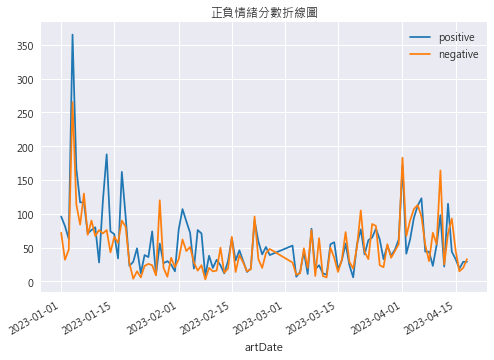

In [ ]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖")
plt.show()

-正負情緒最高的地方，基本上都落在公布要普發6000的時候，正面情緒略高於負面情緒。<br>
-在負面情緒分數很高的地方，應該是連假那段時間，很多人沒領到錢的時候。<br>
-雖然正面情緒分數的最高高於負面情緒分數的最高，但整體的情緒分數量分布差不多(很多重疊的部分，同樣也可以在情緒比例折線圖那邊看到)，可以代表各有支持的一方。

In [ ]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
0,2023-01-01,affect,187,0.054678
1,2023-01-01,anger,17,0.004971
2,2023-01-01,anx,13,0.003801
3,2023-01-01,negative,72,0.021053
4,2023-01-01,positive,96,0.028070
...,...,...,...,...
693,2023-04-18,anger,11,0.011044
694,2023-04-18,anx,2,0.002008
695,2023-04-18,negative,33,0.033133
696,2023-04-18,positive,29,0.029116


In [ ]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

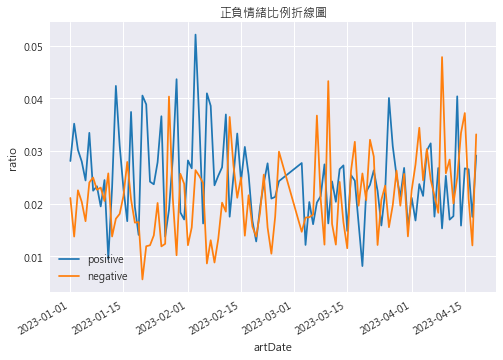

In [ ]:
fig, ax = plt.subplots()

rolling_days = 1
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

-前面正面情緒比例略高於負面情緒<br>
-但後面負面情緒略高於正面情緒，可能是因為有些人領不到錢的關係

## 1/4 最多發文日

In [ ]:

from collections import Counter
date = "2023-01-04"
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


[('6000', 186),
 ('政府', 140),
 ('發現', 105),
 ('全民', 85),
 ('億元', 63),
 ('台灣', 61),
 ('現金', 61),
 ('超徵', 61),
 ('八卦', 58),
 ('新聞', 57),
 ('經濟', 54),
 ('繳稅', 54),
 ('稅收', 52),
 ('蕭景田', 47),
 ('每人', 46),
 ('預算', 46),
 ('蘇貞昌', 45),
 ('希望', 44),
 ('公平', 42),
 ('完整', 42)]

(-0.5, 799.5, 399.5, -0.5)

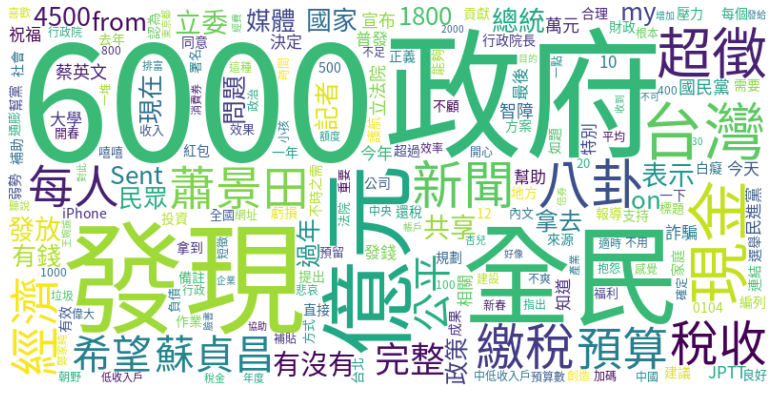

In [ ]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, width=800, height = 400, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(14, 7))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

可以大概看一下1/4(普發6000公佈)的時候，因為正、負面情緒分數比較高，可以看到有一些超徵、政府、還有一些相關人士在文字雲上面出現。

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


(-0.5, 799.5, 399.5, -0.5)

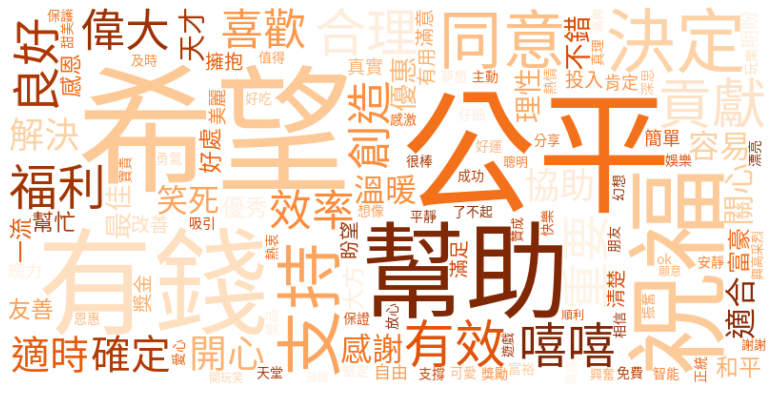

In [ ]:
date = "2023-01-04"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, width=800, height = 400, background_color="white", font_path=font_path, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(14, 7))
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

可以看到大部分正向的情緒是有錢可以拿，所以覺得比較開心。

1/4負面詞彙文字雲

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


(-0.5, 799.5, 399.5, -0.5)

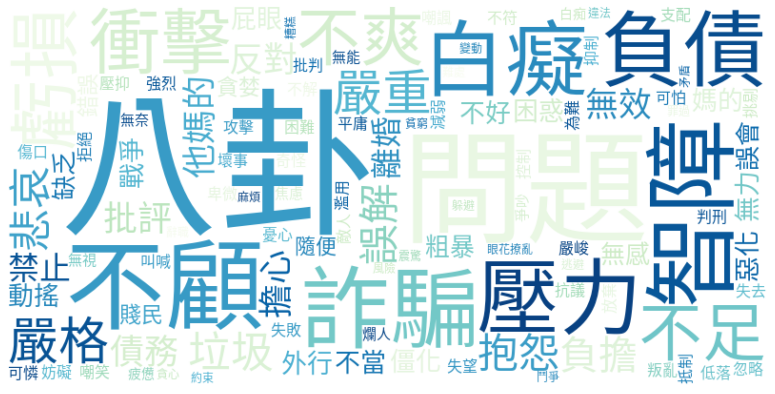

In [ ]:
date = "2023-01-04"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, width=800, height = 400, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(14, 7))
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

In [ ]:
date = '2023-01-04'
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"].isin(['positive', 'negative'])
)

ptt_df_date = ptt_liwc_df.loc[mask, ["artDate", "word", "sentiments"]]
ptt_df_date_senti = ptt_df_date.groupby(["sentiments", "word"], as_index=False).size()
ptt_df_date_senti.head()

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,sentiments,word,size
0,negative,不好,2
1,negative,不爽,4
2,negative,不當,2
3,negative,不符,1
4,negative,不解,1


C:\Users\user\AppData\Local\Temp\ipykernel_29372\1670547556.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\user\AppData\Local\Temp\ipykernel_29372\1670547556.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


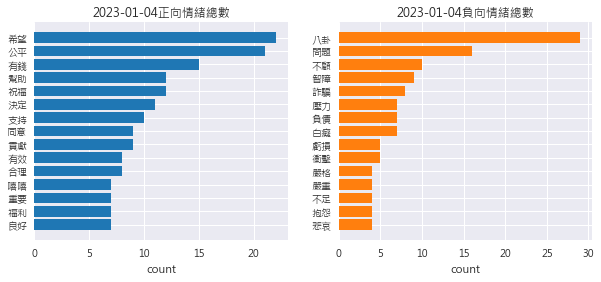

In [ ]:
pos = ptt_df_date_senti[(ptt_df_date_senti["sentiments"] == "positive")].sort_values(
    ["size"], ascending=True
)
pos = pos[-15:]
neg = ptt_df_date_senti[ptt_df_date_senti["sentiments"] == "negative"].sort_values(
    ["size"], ascending=True
)
neg = neg[-15:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_title(f"{date}正向情緒總數")
ax[0].set_yticklabels(pos["word"])

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_title(f"{date}負向情緒總數")
ax[1].set_yticklabels(neg["word"])
plt.show()

## 情緒分數趨勢圖

In [ ]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad
0,2023-01-01,187,17,13,72,96,10
1,2023-01-02,119,5,9,32,82,3
2,2023-01-03,114,13,10,47,63,11
3,2023-01-04,672,69,32,265,365,29
4,2023-01-05,299,42,24,114,167,8


In [ ]:
# sentiment 計算方式: positive - anger - anx - negative - sad
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["anger"]
    - ptt_sentiment_value["anx"]
    - ptt_sentiment_value["negative"]
    - ptt_sentiment_value["sad"]
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad,sentiment_value
0,2023-01-01,187,17,13,72,96,10,-16
1,2023-01-02,119,5,9,32,82,3,33
2,2023-01-03,114,13,10,47,63,11,-18
3,2023-01-04,672,69,32,265,365,29,-30
4,2023-01-05,299,42,24,114,167,8,-21


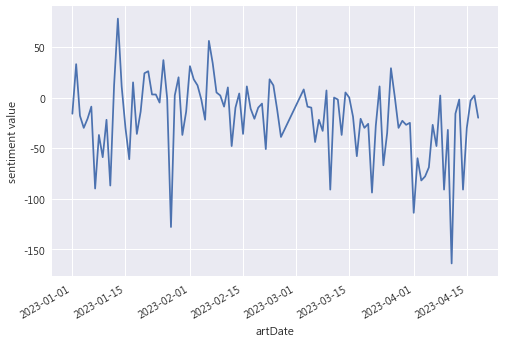

In [ ]:
fig, ax = plt.subplots()

rolling_days = 1
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()

## CKIP&NER

In [ ]:
# 安裝會使用到的套件
# 安裝ckiptagger前要先安裝tensorflow，有套件相依的問題
%pip install ckiptagger[tf,gdown] wordcloud SnowNLP

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# 確認當前工作目錄
%pwd

'c:\\Users\\user\\Desktop\\社群媒體\\mid-project'

In [ ]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta


In [ ]:
# 將三份工具的模型路徑指向我們剛才下載的 data.zip
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ckipta

In [ ]:
# 自定義辭典
with open('dict/user_dict.txt',encoding="utf-8") as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'郵局': 500.0}), (3, {'蔡英文': 500.0, '蘇貞昌': 500.0, '身分證': 500.0, '居留證': 500.0}), (4, {'直接入帳': 500.0, '特定偏鄉': 500.0, '登記入帳': 500.0}), (5, {'ATM領現': 500.0, '青春動滋券': 500.0, '藝FUN券': 500.0}), (7, {'疫後特別預算案': 500.0})]


In [ ]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), str(article).split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [ ]:
# 自定義辭典
with open('dict/user_dict.txt',encoding="utf-8") as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'郵局': 500.0}), (3, {'蔡英文': 500.0, '蘇貞昌': 500.0, '身分證': 500.0, '居留證': 500.0}), (4, {'直接入帳': 500.0, '特定偏鄉': 500.0, '登記入帳': 500.0}), (5, {'ATM領現': 500.0, '青春動滋券': 500.0, '藝FUN券': 500.0}), (7, {'疫後特別預算案': 500.0})]


In [ ]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [ ]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 1625.8273150920868


In [ ]:
pos_table.head()

,system_id,word,pos
0,1,確定,VK
1,1,不會,D
2,1,普發,VC
3,1,現金,Na
4,1,蔡英文,Nb


In [ ]:
entity_table.head()

,system_id,word,ner
0,1,蔡英文,PERSON
1,1,蔡英文,PERSON
2,1,賴清德,PERSON
3,1,中華民國,GPE
4,1,李毓康,PERSON


In [ ]:
sentence_table.head()

,system_id,sentence
0,1,確定不會普發現金蔡英文決定不容易
1,1,為了國家請國人理解
2,1,▲總統蔡英文副總統賴清德出席中華民國年元旦總統府升旗典禮
3,1,圖記者李毓康
4,1,攝


In [ ]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") 
print(f"posts have NER: {len(entity_table['system_id'].unique())}") 

total posts numbers: 2088
posts have NER: 1880


In [ ]:
# 將文章存成csv
pos_table.to_csv('raw_data/pos_table.csv', index = False)
entity_table.to_csv('raw_data/entity_table.csv', index = False)
sentence_table.to_csv('raw_data/sentence_table.csv', index = False)

In [ ]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/pos_table.csv") 
entity_table = pd.read_csv("raw_data/entity_table.csv") 
sentence_table = pd.read_csv("raw_data/sentence_table.csv") 

In [ ]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
13,PERSON,7325
11,ORG,6070
4,GPE,4750
1,DATE,4188
0,CARDINAL,2464
8,MONEY,1651
9,NORP,586
16,TIME,556


C:\Users\user\AppData\Local\Temp\ipykernel_29372\462156543.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


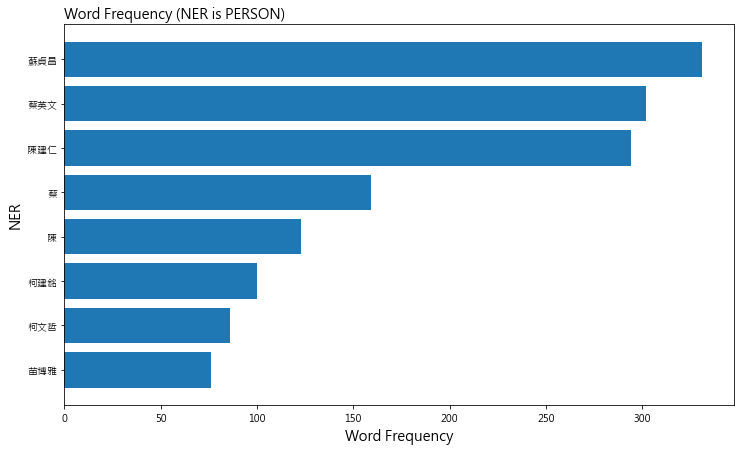

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

-可以看到大部分討論的人物都跟這次普發6000有關，一個是前行政院長蘇貞昌，第二個則是總統蔡英文，第三個是現任行政院長陳建仁。

C:\Users\user\AppData\Local\Temp\ipykernel_29372\1011022482.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


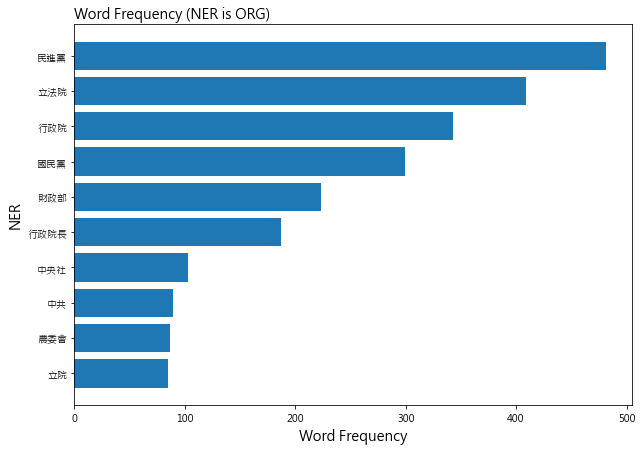

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

組織也基本上都跟這次普發6000有關

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
word = ner_count['word']
count = ner_count['count']


In [ ]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count


,pos,count
15,Na,85472
5,D,41583
35,VC,32684
41,VH,21678
17,Nc,18027
29,P,14477
6,DE,12649
38,VE,12489
16,Nb,10391
25,Nf,10244


In [ ]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)

C:\Users\user\AppData\Local\Temp\ipykernel_29372\1614676684.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


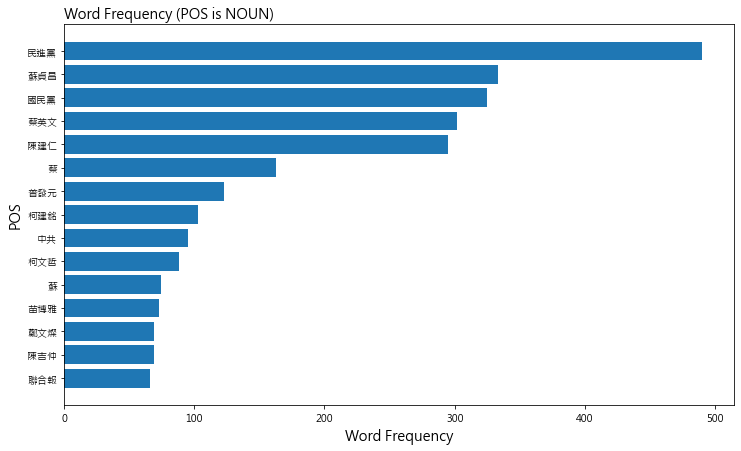

In [ ]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

民進黨、蘇貞昌、國民黨、蔡英文、陳建仁......

## SNOWNLP

In [ ]:
from snownlp import SnowNLP
s = SnowNLP('都拿不到錢')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.11861022172676727

In [ ]:
keyword_list = ['普發']
df['artContent'] = df['artContent'].fillna('')  # 填充缺失值
p6_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{p6_selected.shape[0]}篇相關貼文")
p6_selected.head(3)

普發：544篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,[新聞]確定不會普發現金蔡英文：決定不容易！,2023-01-01 09:07:05,s27052705,Gossiping,確定不會普發現金 蔡英文：決定不容易！為了國家請國人理解\n\nETtoday\n\n▲總統...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""deepdish"", ""...",49.217.238.217,2023-01-02 01:27:37,ptt
6,7,https://www.ptt.cc/bbs/Gossiping/M.1672540019....,[新聞]全民共享1800億藍委喊加碼發現金,2023-01-01 10:26:54,JamesSoong,Gossiping,1.媒體來源:\n\n 中國時報\n\n2.記者署名:\n\n ...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""hikaru77613""...",27.247.1.83,2023-01-02 01:28:17,ptt
7,8,https://www.ptt.cc/bbs/Gossiping/M.1672540538....,[新聞]元旦談話／發現金或消費券不可能了？蔡,2023-01-01 10:35:35,b10485762000,Gossiping,1.媒體來源:聯合報\n\n2.記者署名:聯合報／ 記者丘采薇／台北即時報導\n\n3.完整...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""LouisLEE"", ""...",118.166.9.63,2023-01-02 01:28:25,ptt


In [ ]:
sentence_table = pd.read_csv("raw_data/sentence_table.csv") #匯資料

sentiment_date = pd.merge(sentence_table,p6_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

,system_id,sentence,artDate,dataSource
0,1,確定不會普發現金蔡英文決定不容易,2023-01-01 09:07:05,ptt
1,1,為了國家請國人理解,2023-01-01 09:07:05,ptt
2,1,▲總統蔡英文副總統賴清德出席中華民國年元旦總統府升旗典禮,2023-01-01 09:07:05,ptt
3,1,圖記者李毓康,2023-01-01 09:07:05,ptt
4,1,攝,2023-01-01 09:07:05,ptt


In [ ]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
0,1,確定不會普發現金蔡英文決定不容易,2023-01-01 09:07:05,ptt,0.877771
1,1,為了國家請國人理解,2023-01-01 09:07:05,ptt,0.629881
2,1,▲總統蔡英文副總統賴清德出席中華民國年元旦總統府升旗典禮,2023-01-01 09:07:05,ptt,0.295159
3,1,圖記者李毓康,2023-01-01 09:07:05,ptt,0.398535
4,1,攝,2023-01-01 09:07:05,ptt,0.833333


In [ ]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    1.385000e+04
mean     4.262367e-01
std      3.410148e-01
min      5.107026e-15
25%      9.475547e-02
50%      3.790299e-01
75%      7.297954e-01
max      1.000000e+00
Name: sentimentValue, dtype: float64

情緒分數平均大約為在0.4，是個比較中性的數字，也挺符合ptt上面情緒會比較負面的情況

<AxesSubplot:>

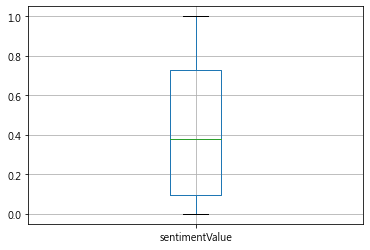

In [ ]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [ ]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count.head()

,artDate,sentimentValue
0,2023-01,0.418840
1,2023-02,0.427776
2,2023-03,0.434511
3,2023-04,0.436195


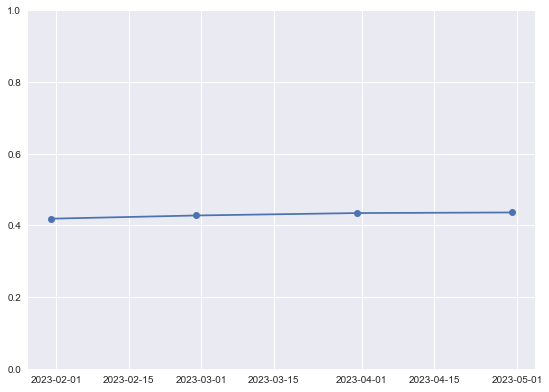

In [ ]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

## 算TF-IDF

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

In [ ]:
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

In [ ]:
# 移除網址格式
df.fillna('', inplace=True)
df['sentence'] = df.artContent.apply(lambda x: re.sub('(http|https)://.*', '', x))

# 只留下中文字
df['sentence'] = df.artContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',x))
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,[新聞]確定不會普發現金蔡英文：決定不容易！,2023-01-01 09:07:05,s27052705,Gossiping,確定不會普發現金 蔡英文：決定不容易！為了國家請國人理解\n\nETtoday\n\n▲總統...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""deepdish"", ""...",49.217.238.217,2023-01-02 01:27:37,ptt,確定不會普發現金蔡英文決定不容易為了國家請國人理解總統蔡英文副總統賴清德出席中華民國年元旦總...
1,2,https://www.ptt.cc/bbs/Gossiping/M.1672536103....,Re:[新聞]確定不會普發現金蔡英文：決定不容易！,2023-01-01 09:21:41,s523698,Gossiping,勞健保虧損要去補吧\n\n油跟天然氣的價格\n\n不跟國際連動\n\n吸收虧損很久了\n\n...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""kinve1014"", ...",36.227.208.129,2023-01-02 01:27:45,ptt,勞健保虧損要去補吧油跟天然氣的價格不跟國際連動吸收虧損很久了有超徵拿來補洞還不錯阿
2,3,https://www.ptt.cc/bbs/Gossiping/M.1672536453....,[問卦]為啥一堆人講的兩萬六很多一樣？,2023-01-01 09:27:31,Jyery,Gossiping,yo\n\n為啥看臉書跟ptt一堆人講的進去當一年 一個月兩萬六一樣 而且實拿才兩萬\n講的...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""boy1031"", ""c...",180.217.20.59,2023-01-02 01:27:45,ptt,為啥看臉書跟一堆人講的進去當一年一個月兩萬六一樣而且實拿才兩萬講的好像關在裡面一年後出來有萬...


In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [ ]:
data = df.copy()
data['word'] = data.sentence.apply(getToken)

# 將word欄位展開
data = data.explode('word')

data.head(3)

Building prefix dict from c:\Users\user\Desktop\社群媒體\mid-project\dict\dict.txt.big ...
Dumping model to file cache C:\Users\user\AppData\Local\Temp\jieba.u2736c2ac2c630efcca67dbbe243aaeda.cache
Loading model cost 1.360 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,[新聞]確定不會普發現金蔡英文：決定不容易！,2023-01-01 09:07:05,s27052705,Gossiping,確定不會普發現金 蔡英文：決定不容易！為了國家請國人理解\n\nETtoday\n\n▲總統...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""deepdish"", ""...",49.217.238.217,2023-01-02 01:27:37,ptt,確定不會普發現金蔡英文決定不容易為了國家請國人理解總統蔡英文副總統賴清德出席中華民國年元旦總...,確定
0,1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,[新聞]確定不會普發現金蔡英文：決定不容易！,2023-01-01 09:07:05,s27052705,Gossiping,確定不會普發現金 蔡英文：決定不容易！為了國家請國人理解\n\nETtoday\n\n▲總統...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""deepdish"", ""...",49.217.238.217,2023-01-02 01:27:37,ptt,確定不會普發現金蔡英文決定不容易為了國家請國人理解總統蔡英文副總統賴清德出席中華民國年元旦總...,發現
0,1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,[新聞]確定不會普發現金蔡英文：決定不容易！,2023-01-01 09:07:05,s27052705,Gossiping,確定不會普發現金 蔡英文：決定不容易！為了國家請國人理解\n\nETtoday\n\n▲總統...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""deepdish"", ""...",49.217.238.217,2023-01-02 01:27:37,ptt,確定不會普發現金蔡英文決定不容易為了國家請國人理解總統蔡英文副總統賴清德出席中華民國年元旦總...,金蔡


In [ ]:
# 每篇文章的總詞彙數
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,232
1,https://www.ptt.cc/bbs/Gossiping/M.1672536103....,13
2,https://www.ptt.cc/bbs/Gossiping/M.1672536453....,36
3,https://www.ptt.cc/bbs/Gossiping/M.1672536809....,35
4,https://www.ptt.cc/bbs/Gossiping/M.1672538276....,14
...,...,...
2084,https://www.ptt.cc/bbs/Gossiping/M.1681813743....,391
2085,https://www.ptt.cc/bbs/Gossiping/M.1681815044....,23
2086,https://www.ptt.cc/bbs/Gossiping/M.1681817470....,20
2087,https://www.ptt.cc/bbs/Gossiping/M.1681820239....,32


In [ ]:
# 計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,一事,1
1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,三則,1
2,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,下來,1
3,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,不時之需,3
4,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,中央,2
...,...,...,...
144160,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,頂樓,1
144161,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,頑皮,1
144162,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,風景區,1
144163,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,飲料,1


In [ ]:
p6_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
p6_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,一事,1,232
1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,三則,1,232
2,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,下來,1,232
3,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,不時之需,3,232
4,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,中央,2,232
...,...,...,...,...
144160,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,頂樓,1,230
144161,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,頑皮,1,230
144162,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,風景區,1,230
144163,https://www.ptt.cc/bbs/Gossiping/M.1681822039....,飲料,1,230


In [ ]:
# 計算tf
p6_words_tf_idf = p6_words.assign(tf = p6_words.iloc[:,2]/p6_words.iloc[:,3])
p6_words_tf_idf.head()

,artUrl,word,count,total,tf
0,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,一事,1,232,0.004310
1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,三則,1,232,0.004310
2,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,下來,1,232,0.004310
3,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,不時之需,3,232,0.012931
4,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,中央,2,232,0.008621


In [ ]:
# 計算每個詞彙出現在幾篇文章中
idf_df = p6_words.groupby(['word'],as_index=False).size()
p6_words_tf_idf = p6_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
p6_words_tf_idf.head()

,artUrl,word,count,total,tf,size
0,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,一事,1,232,0.004310,19
1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,三則,1,232,0.004310,26
2,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,下來,1,232,0.004310,80
3,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,不時之需,3,232,0.012931,27
4,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,中央,2,232,0.008621,97


In [ ]:
# 計算idf
p6_words_tf_idf = p6_words_tf_idf.assign(idf = p6_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

p6_words_tf_idf = p6_words_tf_idf.drop(labels=['size'],axis=1)
p6_words_tf_idf.head()

,artUrl,word,count,total,tf,idf
0,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,一事,1,232,0.004310,2.041185
1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,三則,1,232,0.004310,1.904965
2,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,下來,1,232,0.004310,1.416848
3,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,不時之需,3,232,0.012931,1.888575
4,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,中央,2,232,0.008621,1.333167


In [ ]:
# 計算tf*idf
p6_words_tf_idf = p6_words_tf_idf.assign(tf_idf = p6_words_tf_idf.iloc[:,4] * p6_words_tf_idf.iloc[:,5])
p6_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,一事,1,232,0.004310,2.041185,0.008798
1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,三則,1,232,0.004310,1.904965,0.008211
2,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,下來,1,232,0.004310,1.416848,0.006107
3,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,不時之需,3,232,0.012931,1.888575,0.024421
4,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,中央,2,232,0.008621,1.333167,0.011493


In [ ]:
# 從每篇文章挑選出tf-idf最大的前十個詞
(p6_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
11364,銀行,63
8065,登記,59
1620,入帳,55
1743,八卦,37
7736,特別,35
1814,六千,33
8134,發放,33
1453,億元,32
3223,國民黨,31
11831,領到,31


## Bigram 預測模型

In [ ]:
data3 = df.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [ ]:
def ngram(documents, N=2):
    ngram_prediction = {}
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [ ]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

In [ ]:
text = '普發'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 千元, probability: 0.114
next word: 六千, probability: 0.0995
next word: 台幣, probability: 0.0474
next word: 萬元, probability: 0.0474
next word: 六千元, probability: 0.0427


In [ ]:
text = '王道'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 銀行, probability: 0.556
next word: 登記, probability: 0.0242
next word: 偷跑, probability: 0.0242
next word: 今天, probability: 0.0242
next word: 搶先, probability: 0.0161


輸入王道銀行的字，除了銀行，居然還會出現「偷跑、搶先」等字眼，可以顯示出當時王道銀行提前偷跑的情況

In [ ]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [ ]:
p6_bigram2 = df.copy()
p6_bigram2["word"] = p6_bigram2.sentence.apply(bigram_getToken_dict)

In [ ]:
p6_bigram2 = p6_bigram2.explode('word')
p6_bigram2.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,[新聞]確定不會普發現金蔡英文：決定不容易！,2023-01-01 09:07:05,s27052705,Gossiping,確定不會普發現金 蔡英文：決定不容易！為了國家請國人理解\n\nETtoday\n\n▲總統...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""deepdish"", ""...",49.217.238.217,2023-01-02 01:27:37,ptt,確定不會普發現金蔡英文決定不容易為了國家請國人理解總統蔡英文副總統賴清德出席中華民國年元旦總...,確定 發現
0,1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,[新聞]確定不會普發現金蔡英文：決定不容易！,2023-01-01 09:07:05,s27052705,Gossiping,確定不會普發現金 蔡英文：決定不容易！為了國家請國人理解\n\nETtoday\n\n▲總統...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""deepdish"", ""...",49.217.238.217,2023-01-02 01:27:37,ptt,確定不會普發現金蔡英文決定不容易為了國家請國人理解總統蔡英文副總統賴清德出席中華民國年元旦總...,發現 金蔡
0,1,https://www.ptt.cc/bbs/Gossiping/M.1672535227....,[新聞]確定不會普發現金蔡英文：決定不容易！,2023-01-01 09:07:05,s27052705,Gossiping,確定不會普發現金 蔡英文：決定不容易！為了國家請國人理解\n\nETtoday\n\n▲總統...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""deepdish"", ""...",49.217.238.217,2023-01-02 01:27:37,ptt,確定不會普發現金蔡英文決定不容易為了國家請國人理解總統蔡英文副總統賴清德出席中華民國年元旦總...,金蔡 英文


In [ ]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('完整', '新聞'), 759),
 (('媒體', '來源'), 390),
 (('完整', '新聞標題'), 384),
 (('新聞', '連結'), 379),
 (('記者', '署名'), 370)]

In [ ]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [ ]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

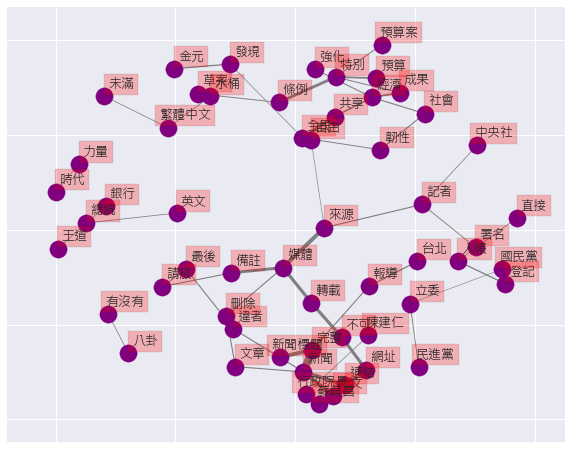

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)
bbox = {}
# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox={'facecolor': 'red', 'alpha': 0.25},
            horizontalalignment='center', fontsize=13)
    
plt.show()

這張圖實際上呈現了許多有關普發6000的相關詞彙以及其之間的聯繫，像王道跟銀行、總統跟英文、直接跟入帳等詞彙。

In [ ]:
#計算phi值
def phi_cor(df_2):
    # total x
    nx = len(set(word_count2[word_count2["word"]==df_2["word"]]["artUrl"]))
    tnx = len(df)-nx
    # total y
    ny = len(set(word_count2[word_count2["word"]==df_2["word2"]]["artUrl"]))
    tny = len(df)-ny
    # 有x 有y
    x_ls = list(word_count2[word_count2["word"]==df_2["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==df_2["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    # 有x 沒有y
    nxo = nx-nxy
    # 沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(df["artUrl"]))-uxy) #取差集:全-有x有y
    # 沒有x 有y
    noy = ny-nxy
    # print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [ ]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [ ]:
p_sum = bigram_df[(bigram_df["word"]=="普發")].sort_values(by=['cor'], ascending = False).head(10)
six_sum = bigram_df[(bigram_df["word"]=="王道")].sort_values(by=['cor'], ascending = False).head(10)

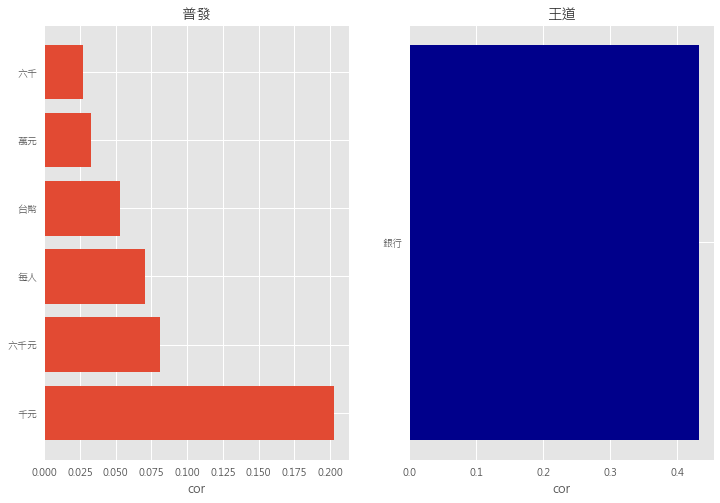

In [ ]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('普發')
plt.xlabel('cor')
plt.barh(p_sum['word2'],p_sum['cor'])

plt.subplot(122)
plt.title('王道')
plt.xlabel('cor')
plt.barh(six_sum['word2'],six_sum['cor'],color="darkblue")


plt.show()

會是千元應該是在篩資料的時候將數字去掉了

為了更深入探討民眾對於普發6000的正反意見，<br>
我們將ptt文章的留言同樣進行文字分析<br>

In [10]:
from datetime import datetime
from collections import Counter

import jieba
import jieba.analyse
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
from matplotlib.font_manager import FontProperties

# 設定圖的字體
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['STXihei'] 
plt.rcParams['axes.unicode_minus'] = False

# 設定中文字體(cloud的標題)
import matplotlib.font_manager as fm
fprop = fm.FontProperties(fname="raw_data/SourceHanSansTW-Regular.otf")

## 4.留言內容分析

<h3>ptt文章留言詞頻分析</h3>
Step 1. 資料蒐集<br>

In [11]:
#ptt 八卦版 202209-202304 "6000"關鍵字爬蟲
df_c = pd.read_csv('./new_ptt6000.csv')

#去除有包含空值的筆數
df_c =df_c.dropna(axis=0, how='any')

Step 2. 將ptt留言篩出，ptt評論整理成string放進新增的欄位['comment']

In [12]:
import json

# 取出 artComment 此json格式的欄位中的 cmtContent 和 cmtStatus
cmtContent_list = []
cmtStatus_list = []

# 先將缺失值填補為空字串
df_c['artComment'] = df_c['artComment'].fillna('')

for idx, a in enumerate(df_c['artComment']):
    json_arr = json.loads(a)
    for obj in json_arr:
        cmtContent = obj['cmtContent'].replace(':', '')  # create a new variable for cmtContent and use replace method
        cmtContent_list.append(cmtContent)
        cmtStatus_list.append(obj['cmtStatus'])
    
    # Convert cmtContent_list to a string and add it to the comment column of df_c
    df_c.at[idx, 'comment'] = ','.join(cmtContent_list)

    # Add cmtStatus_list to the commentStatus column of df_c
    df_c.at[idx, 'commentStatus'] = ','.join(cmtStatus_list)

    # Clear cmtContent_list and cmtStatus_list for the next row
    cmtContent_list.clear()
    cmtStatus_list.clear()

# df_c.head(3)

Step 3.資料初步清理

In [13]:
#ptt常用兩個換行符號作為句子的結尾，因此將兩個換行取代為句號，並清除不重要的字如換行、網址

#去除有包含空值的筆數
df_c.dropna(axis=0, how='any')

#用'。'取代'\n\n'，並移除'\n'
df_c = df_c.replace(r'\\n\\n', '。', regex=True).replace(r'\n', '', regex=True)

#移除內文中的網址
df_c['comment'] = df_c['comment'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

# df_c.head(1)


Step 4.斷句<br>
中文主要以標點符號進行斷句，並清除空的字串

In [14]:
df_c['comment'] = df_c['comment'].str.split("[,，。！!？?]{1,}")

df_c = df_c.explode('comment').reset_index(drop=True)


# 把長度小於1的content刪掉
df_c = df_c[df_c["comment"].str.len() > 1]

# df_c.head(2)

Step 5. 斷詞<br>
斷詞引擎設定：使用 Jieba 當作斷詞系統。 另外可能還有一些專有名詞是沒有被包含在預設字典當中，我們也可以使用自定義字典的方式加入，或者使用參數的形式帶入。

In [15]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
# 將自訂的emo_dict改為以下字詞:
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')

#斷詞前先將標點符號清除，並清除空字串
df_c['comment'] = df_c['comment'].str.replace(r'[^\w\s\d]+', '', regex=True).astype(str)

df_c = df_c[df_c["comment"].str.len() > 1]


Building prefix dict from c:\Users\USER\OneDrive\桌面\comment\dict\dict.txt ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.uc0a4c035f8f298c7fb00f91082c1c8aa.cache
Loading model cost 0.674 seconds.
Prefix dict has been built successfully.


Step 6.使用jieba進行斷詞

In [16]:
df_c = df_c.assign(word = df_c['comment'].apply(jieba.lcut)).explode('word').drop(['comment'], axis=1)
df_c = df_c.loc[df_c['word'].str.len()>1]

Step 7. 移除停用字

In [17]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
# 新增目前、連結、標題、知道、報導、指出....等停用字
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

#移除dataframe中的停用字
df_c_stop = df_c[~df_c['word'].isin(stopwords)]

Step 8.計算詞頻

In [18]:
df_feq = pd.DataFrame({'freq':df_c_stop.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
df_feq = df_feq[clist]


Step.9  更新停用字字典，並更新資料

In [19]:
# 參數形式手動加入停用字
stopwords_manual = ['知道','現在','一堆','不用','直接','這種','根本','好了','一下','繼續']
stopwords.extend(stopwords_manual)
df_c_stop2 = df_c_stop[~df_c_stop['word'].isin(stopwords)]

#重新計算詞頻
df_feq2 = pd.DataFrame({'freq':df_c_stop2.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)
clist = ['word','freq']  
df_feq2 = df_feq2[clist]

# 重新繪製詞頻長條圖
# df_feq2.iloc[:15].plot.barh(x='word', y='freq').invert_yaxis()
# plt.show()


Step 10. 繪製文字雲

(-0.5, 799.5, 399.5, -0.5)

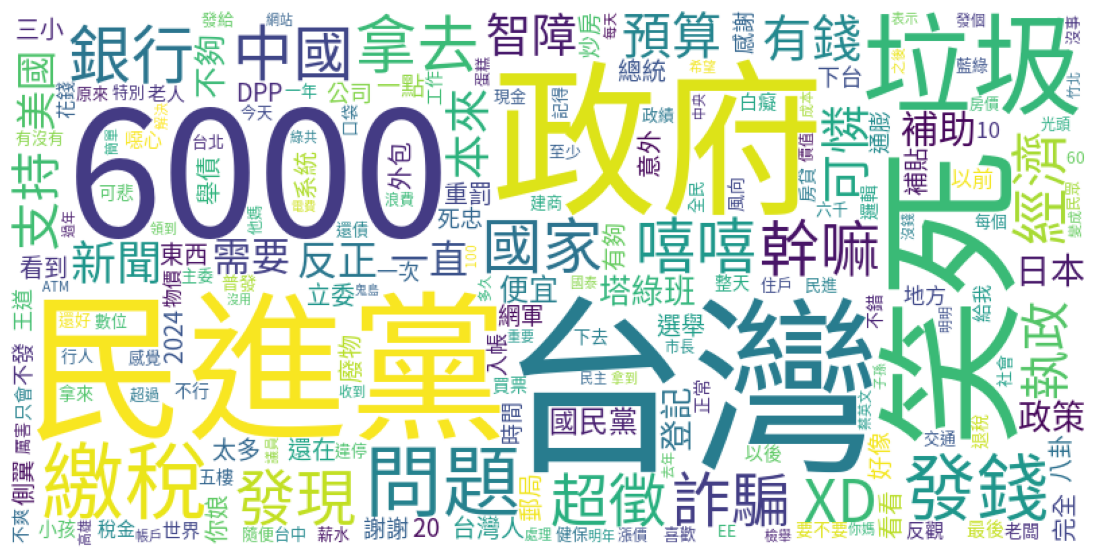

In [20]:
# 詞頻變成dict
fdict = df_feq2.set_index('word', inplace=False).to_dict()
fdict= fdict['freq']

# 繪製文字雲
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' # 設定字型 (字體包)
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=FontPath, max_words=200)
wordcloud.generate_from_frequencies(fdict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis('off')
# 儲存並顯示文字雲
# plt.savefig('wordcloud.png', bbox_inches='tight')

可以看到ptt留言對於普發六千出現頻率高的字眼有: 笑死、垃圾、問題、嘻嘻等充滿諷刺意味的詞彙，
可以推斷ptt評論的情緒分佈應該較為負面。

<br>

<h3>lexicon-base 情緒分析</h3>

In [22]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

將情緒字典與斷詞結果進行合併。

In [26]:
df_c_liwc = pd.merge(df_c_stop2[["artDate", "word"]], liwc_dict, how="left")
# df_c_liwc

正向（positive）與負向（negative）情緒的折線圖

C:\Users\USER\AppData\Local\Temp\ipykernel_14104\1540193744.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos["artDate"] = pd.to_datetime(pos["artDate"]) # convert to datetime if not already in datetime format
C:\Users\USER\AppData\Local\Temp\ipykernel_14104\1540193744.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg["artDate"] = pd.to_datetime(neg["artDate"]) # convert to datetime if not already in datetime format


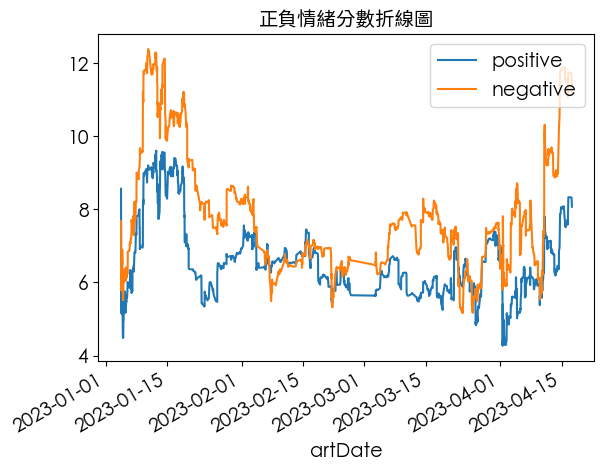

In [27]:
sentiment_c_count = pd.DataFrame(
    df_c_liwc.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_c_count = sentiment_c_count.rename(columns={0: "size"})
sentiment_c_count = sentiment_c_count.sort_values(["artDate"])

colors = ["tab:blue", "tab:orange"]
pos = sentiment_c_count[sentiment_c_count["sentiments"] == "positive"]
neg = sentiment_c_count[sentiment_c_count["sentiments"] == "negative"]

pos["artDate"] = pd.to_datetime(pos["artDate"]) # convert to datetime if not already in datetime format
neg["artDate"] = pd.to_datetime(neg["artDate"]) # convert to datetime if not already in datetime format

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 100天移動平均
rolling_days = 100
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

可以看出ptt的評論的負面情緒大多高於正面情緒，<br>
而發文內容幾乎都是正向。<br>
因此我們透過文字雲觀察ptt留言有關於普發六千的負面詞彙有哪些:

#
#
2023-04-11 文字雲<br>
此日是2023年以來，有關普發6000的ptt評論，負面分數最高的一天，<br>
而台灣在4/10 開放「ATM領現」，馬上就有新聞報導ATM領取6000失敗的消息，<br>
因此我們想透過文字雲查看這天的負面情緒詞彙，查看是否與ATM領現有關聯

In [28]:
mask = sentiment_c_count['sentiments'] == 'positive'
sentiment_c_count.loc[mask,:].sort_values("size", ascending=False).head() #字詞數越大排前

date = "2023-04-11"

df_c_liwc['artDate'] = pd.to_datetime(df_c_liwc['artDate'])
df_c_liwc['artDate'] = df_c_liwc['artDate'].dt.date

mask = (df_c_liwc['artDate'] == pd.Timestamp(date).date())
df_c_wc = df_c_liwc.loc[mask, ["artDate", "word"]]
df_c_wc
c_wc = df_c_wc.groupby(["word"]).size().to_dict()
# Counter(c_wc).most_common(20)

(-0.5, 399.5, 199.5, -0.5)

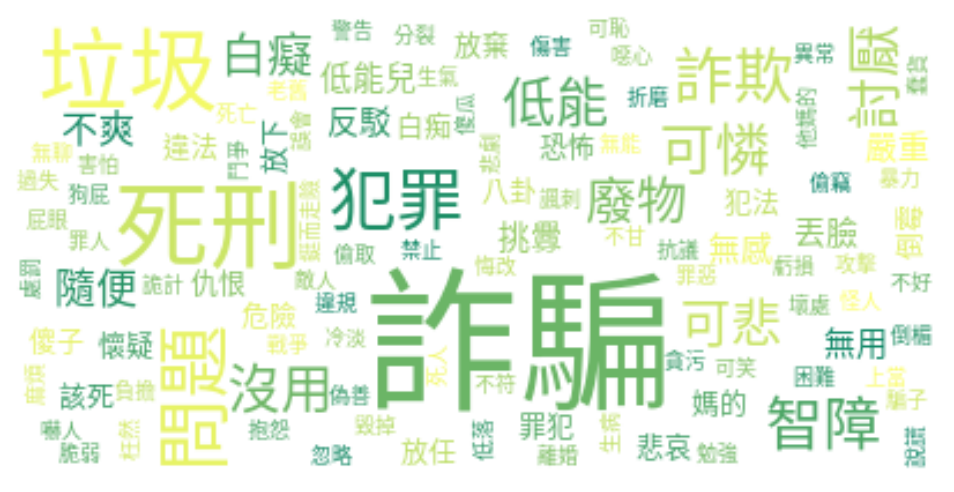

In [29]:

font_path = "raw_data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
###負面
mask = (df_c_liwc["artDate"] == pd.Timestamp(date).date()) & (
    df_c_liwc["sentiments"] == "negative"
)
ptt_df_wc = df_c_liwc.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="summer")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")

詐騙、重罰、死刑這些詞彙占比最大<br>
會出現此詞彙的原因在於ptt有幾篇文章在討論「普發6000的領取資格」和「衍生犯罪問題」:
+ 「普發6000的領取資格」 : 通緝犯、殺警案的犯人、逃到國外的嫌疑犯......等，為什麼也有領取資格。
+ 「衍生犯罪問題」: 有詐騙集團因應普發6000而發明新的詐騙手法



## 5.結論

從以上分析我們找到了普發六千的負面影響以及其引發的爭議，<br>
顯示民眾對於普發六千的政策不全然是贊同的，<br>
而普發6000的所衍生的詐騙問題政府也需要適時提醒民眾，以避免損失擴大<br>

